In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


K-Means Initiation (by Stefanie)
---------------------------------------------------------------------------------------------------------------------------------------------------

In [2]:
# Just for inspecting (and not forgetting about potentially useful information from) the whole joined dataset
df_jointdata = pd.read_csv('joint_data.csv')
df_jointdata.head()

,route_id,route_linestring,num_of_waypoint,waypoint_longitude,waypoint_latitude,poi_lat_lgt,poi_longitude,poi_latitude,poi_category,poi_name,distance
0,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",133,13.67734,52.43849,POINT (13.6774745 52.4385208),13.677475,52.438521,viewpoint,Müggeleck,0.000138
1,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",282,13.62759,52.44386,POINT (13.6279051 52.444312),13.627905,52.444312,bench,NaN,0.000551
2,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",288,13.62704,52.44442,POINT (13.6271595 52.4444457),13.627159,52.444446,bench,NaN,0.000122
3,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",288,13.62704,52.44442,POINT (13.6269487 52.4444808),13.626949,52.444481,bench,NaN,0.000110
4,113043,"LINESTRING (13.69072 52.45147, 13.69075 52.451...",292,13.62716,52.44509,POINT (13.6273851 52.4453161),13.627385,52.445316,bench,NaN,0.000319


In [77]:
# Loading extracted poicount data and making it easy to work with
df_poicount = pd.read_csv('category_count_per_route.csv')
df_poicount.fillna(0, inplace = True) # replacing NaN values with 0s, because having counted no poi in fact IS 0
df_poicount = df_poicount.apply(np.int64)
df_poicount.rename(columns={"wp_count": "wp", "poi_count": "poi", "tree_count": "tree", "bench_count": "bench", "bench_count.1": "restaurant", "cafe_count": "cafe", "atm_count": "atm", "convenience_count": "convenience", "bar_count": "bar", "ice_cream_count": "ice_cream", "picnic_table_count": "picnic", "viewpoint_count": "viewpoint", "gallery_count": "gallery", "museum_count": "museum", "nightclub_count": "nightclub", "drinking_water_count": "drinking_water", "historic_count": "historic", "tourist_attraction_count": "tourist_attraction"}, inplace=True)
df_poicount.head()

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction
0,3503503,8,14,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2713522,8,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3503504,8,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3568200,8,18,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,3573326,9,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0


Cleaning out the noise?
--------------------------------------------------------------------------------------------------------------------------------------

K-Means is noise sensitive. Since our data has a huge variance both along axis 0 and along axis 1, as can be confirmed by looking at the data exploration files in the visualisation folder, there's lot's of noise to be expected.

In our data, we'll define routes as noise, when they pass along an exceptionaly lange number of points of interest. (Yes, our noise is the routes with more information on it than the other routes.)

If we'd keep those very distinct elements while going with the recommended number of clusters (k) from the elbow or the silhouette method, k-Means wouldn't perform well returning one big cluster and some sprinkeled ones for the clusters with very few elements in it each.

On the other hand, if we'd exclude exceptionally point of interest-enriched routes, then the given number if clusters would be distributed more among the more dense data, to the cost of losing the "best" routes from our joined dataset. This seeming to costly, especially since we would later like to integrate more point of interest data and enrich those existing routes more, that's not a good option either.

The solution we adopted here is to keep the noise and at the same time to raise the number of clusters above what elbow or the silhouette method would recommend. This way, we'll get more clusters even in the very dense part of the data while at still including those routes that are very rich in points of interest.

In [55]:
# filtering out any route that pass by more than 500 points of interest             <-- not applied for the reason explained above
#df_poicount = df_poicount.loc[lambda x: x['poi'] < 500]

In [78]:
# Writing the easier to work with and noise strapped df in a new csv file
df_poicount.to_csv(r'poicount.csv', index=False)

In [79]:
# Calculating the percentage of the feature "tree", thus reminding us of what's special about our dataset
print('Trees make out by far the largest amount in our data.', df_poicount['tree'].sum()/df_poicount.iloc[:, 3:].sum().sum()*100, "% of our points of interest is trees.")

Trees make out by far the largest amount in our data. 79.83184053389533 % of our points of interest is trees.


In [80]:
# Reading poicount data in as numpy arrays
poicount = np.genfromtxt('poicount.csv', delimiter=",", usecols=range(3, 19), skip_header=1)

<AxesSubplot:>

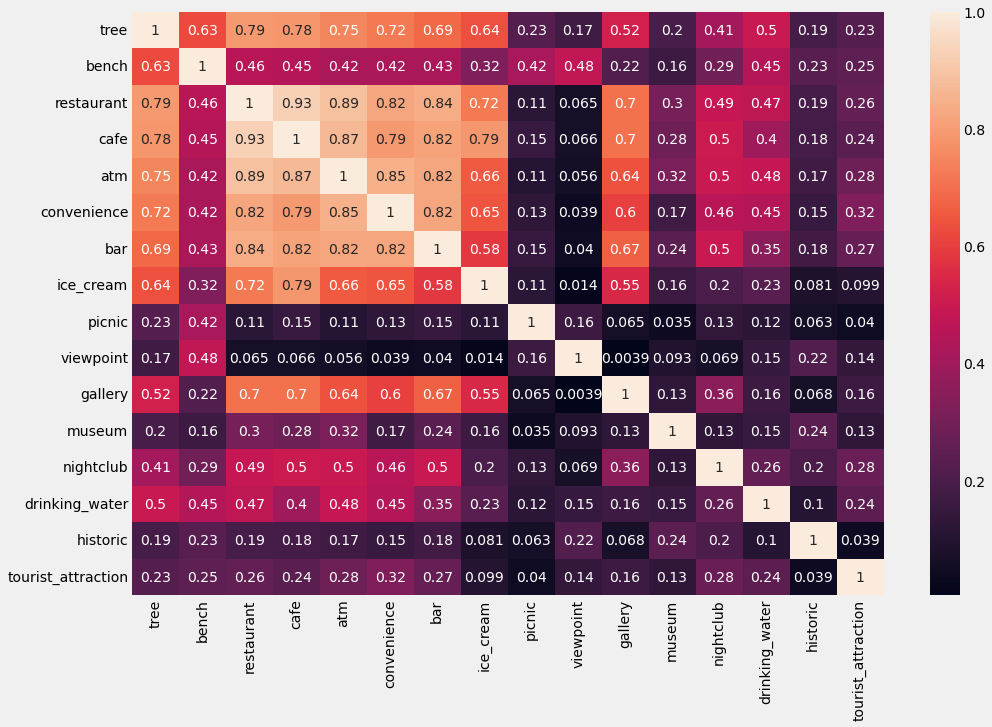

In [81]:
# Getting correlations for all the points of interest (poi)
correlations = df_poicount.iloc[:, 3:].corr()
f,ax=plt.subplots(figsize=(15,10))
sns.heatmap(correlations,annot=True)

Over the thumb summary: 

We can see that restaurants, cafes, convenience shops, atms, bars, ice cream shops, galleries, and trees often come along (meaning being on the same route) with each other. It can be suspected that these togeter will form a cluster. (Sometimes, there's also nightclubs and drinking water on these routes.)

Viewpoints and picnic tables don't correlate with most of the other features, not even with each other, which is surprising. But sometimes they come along with benches, which make sense. 

Trees, surprisingly, don't seem to join the nature routes that often, but tend to be on those routes with shops and cafes. 

Tourist attractions and historic sides don't show a clear correlation and seem to be scattered among the other categories (we only have small amounts of those in our dataset though). 

Nightclubs seem to go best with bars, cafes and atms, but no clear correlation here.

Elbow method for finding the optimal k
-----

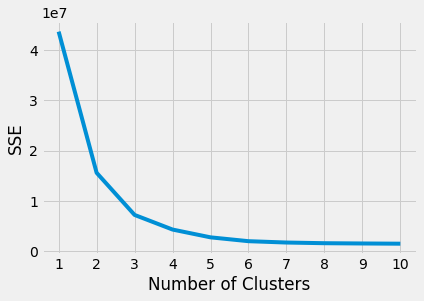

In [82]:
# Increasing k by 1 with every step and store the SSE in a list
kmeans_kwargs = {"init": "random", "n_init": 50, "max_iter": 500}

# Writing the SSE values for each k into a list
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(poicount)
    sse.append(kmeans.inertia_)

# Graphically finding the "elbow", where the SSE and the number of clusters are in reasonable trade-off to each other
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

2 or 3 clusters can be found.

In [83]:
# Using the Python package "kneed" to identify the elbow point programmatically
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

3

3 clusters are recommended.

Silhouette method for finding the optimal k
----------------------

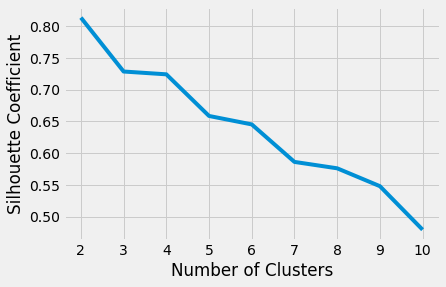

In [84]:
# Making a List for the silhouette coefficients for each k, starting at 2
silhouette_coefficients = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(poicount)
    score = silhouette_score(poicount, kmeans.labels_)
    silhouette_coefficients.append(score)

# Plotting the average silhouette scores for each k
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

This would speak for asuming only 2 clusters. In fact, visualisation shows that most of the data is very densely centered, but the silhouette can only sensefully start at two clusters. By experimenting a bit with the data (not shown here) we found out, that when we'd reduce it to two clusters, then the biggest cluster would "eat" the second biggest cluster, which is a gross loss in information, especially since the biggest cluster is the biggest by far. So, we'll percede with 3 clusters.

For reasons explained in the above section "Cleaning out the noise?", we're not taking the advised k from the elbor or the silhouette method, but we'll add some more clusters.

Implementing KMeans
------------------------------------------------------------------------------------------------------------------------------------

In [85]:
# Initialising the KMeans class, running 50 times with a max of 500 interations each
kmeans = KMeans(init="random", n_clusters=8, n_init=50, max_iter=500)

# Applying the KMeans class to our data: it returns that result with the smallest SSE
kmeans.fit(poicount)

# Getting lables for later mapping these to our dataframe
label = kmeans.labels_

In [86]:
# Looking at the lowest SSE value
kmeans.inertia_

1570020.9677248397

That high number is to be expected, because we have only 430 samples lost in 16 dimensions.

In [88]:
# Number of iterations required to converge
print(kmeans.n_iter_, 'iterations')

30 iterations


In [89]:
# Cluster assignments
kmeans.labels_[:20] #looking at the first 20

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 6, 6, 4, 6, 6, 6, 3, 4, 4])

In [90]:
# Checking how many times each lable appears
unique, counts = np.unique(kmeans.labels_, return_counts=True)
dict(zip(unique, counts))

{0: 34, 1: 35, 2: 14, 3: 51, 4: 76, 5: 14, 6: 203, 7: 3}

One route is the most frequent. By raising k, we can find the subclusters within that very dense centre.

In [91]:
# Assigning the found cluster centres to each feature
cluster_centers = pd.DataFrame(data=kmeans.cluster_centers_, columns = [df_poicount.columns[3:]])
cluster_centers

,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction
0,281.470588,44.264706,10.705882,6.823529,2.500000,1.794118,1.794118,0.705882,0.441176,0.588235,0.617647,0.500000,0.823529,0.470588,0.264706,2.058824e-01
1,433.457143,57.857143,15.600000,8.685714,3.571429,3.828571,2.828571,1.428571,0.457143,0.885714,0.600000,0.571429,0.285714,0.342857,0.228571,2.000000e-01
2,689.000000,63.500000,23.500000,12.785714,5.285714,4.642857,4.928571,2.000000,1.571429,0.500000,0.785714,0.500000,0.357143,0.500000,0.142857,1.387779e-17
3,158.686275,27.196078,7.843137,4.509804,1.803922,1.196078,1.843137,0.588235,0.627451,0.215686,0.333333,0.607843,0.352941,0.137255,0.176471,1.176471e-01
4,65.315789,17.250000,3.131579,1.723684,0.697368,0.486842,0.513158,0.157895,0.065789,0.144737,0.210526,0.131579,0.144737,0.078947,0.078947,6.578947e-02
5,1212.357143,107.285714,37.857143,22.928571,9.500000,4.785714,6.000000,1.642857,1.642857,1.285714,1.571429,1.071429,1.642857,1.428571,0.357143,2.142857e-01
6,6.901478,8.147783,1.699507,0.788177,0.290640,0.128079,0.142857,0.083744,0.359606,0.320197,0.049261,0.093596,0.019704,0.064039,0.039409,4.433498e-02
7,2304.000000,149.333333,90.333333,57.666667,28.333333,31.333333,22.333333,9.000000,1.666667,0.666667,6.000000,0.666667,2.333333,2.333333,0.666667,1.000000e+00


In [119]:
# Comment on the cluster dataframe (so it stays correct with each update)
max_value = max(dict(zip(unique, counts)).values())
max_keys = [k for k, v in dict(zip(unique, counts)).items() if v == max_value]
print('Obviously, "cluster', max_keys, '" stands out for its high procimity to 0! Its the largest cluster and closest to the densest centre.')

Obviously, "cluster [6] " stands out for its high procimity to 0! Its the largest cluster and closest to the densest centre.


K-Means groupes routes regarding their number of points of interest (poi) along into clusters. It wasn't intended to cluster on the number of poi, but rather on the TYPES of features (poi) along the routes. Nonetheless, it seems that the clusters found indicate more interesting and less interesting routes, instead of finding the "cafe and benches" routes, the "trees and nature" routes, the "bars, nightclubs and atms" routes, as we had originally intended to find when we first had started the project.

Because in our data the routes have a very huge variance regarding their number of points of interest they pass by (also see the visualisations in the visualisations folder), we tested if a row wise standardisation of the values would help that.

In [94]:
# Displaying information on the variance in number of points of interest found for each route (consider the std)
df_poicount['poi'].describe()

count     430.000000
mean      211.869767
std       369.018893
min         1.000000
25%        14.000000
50%        62.000000
75%       256.250000
max      3171.000000
Name: poi, dtype: float64

Standardising on axis = 0 (not shown here) though did even seem to make it worse. So, we'll stick to the absolute amounts.

In [100]:
# Mapping our labels into our dataframe (each route gets a cluster label)
df_poicount_cluster = pd.concat([df_poicount, pd.DataFrame({'cluster':label})], join='inner', axis=1)
df_poicount_cluster.head()

,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction,cluster
0,3503503,8,14,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
1,2713522,8,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
2,3503504,8,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
3,3568200,8,18,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
4,3573326,9,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,6


In [101]:
# Writing the enhanced dataframe into a new csv file.
df_poicount_cluster.to_csv('clustered_routes.csv')

In [116]:
# Inspecting clusters
df_clusterinspect = df_poicount_cluster[df_poicount_cluster['cluster'] == 6] # substituting the cluster we're interested in
df_clusterinspect


,route_id,wp,poi,tree,bench,restaurant,cafe,atm,convenience,bar,ice_cream,picnic,viewpoint,gallery,museum,nightclub,drinking_water,historic,tourist_attraction,cluster
0,3503503,8,14,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
1,2713522,8,2,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
2,3503504,8,9,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
3,3568200,8,18,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
4,3573326,9,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3135442,2000,57,18,26,7,3,2,0,1,0,0,0,0,0,0,0,0,0,6
414,3135461,2000,7,1,4,0,0,1,0,0,1,0,0,0,0,0,0,0,0,6
416,2985605,2000,8,2,1,1,0,0,0,0,0,1,2,0,0,0,1,0,0,6
420,3539929,2000,69,23,36,4,4,0,0,0,0,0,0,0,0,1,1,0,0,6


In [133]:
print('Impressions from inspecting each cluster:')
for ele in np.unique(label):
    print('Cluster', np.unique(label)[ele], ': All routes have a very stable amount of trees:', 
    df_poicount_cluster[df_poicount_cluster['cluster'] == np.unique(label)[ele]]['tree'].mean())

Impressions from inspecting each cluster:
Cluster 0 : All routes have a very stable amount of trees: 281.47058823529414
Cluster 1 : All routes have a very stable amount of trees: 433.45714285714286
Cluster 2 : All routes have a very stable amount of trees: 689.0
Cluster 3 : All routes have a very stable amount of trees: 158.68627450980392
Cluster 4 : All routes have a very stable amount of trees: 65.3157894736842
Cluster 5 : All routes have a very stable amount of trees: 1212.357142857143
Cluster 6 : All routes have a very stable amount of trees: 6.901477832512315
Cluster 7 : All routes have a very stable amount of trees: 2304.0


The number of trees seem the be the only real distinction in the data, while all the 0s in the other 15 columns, tear the whole data down to a single, dense centre.

Principal Component Analysis and plotting in 2D
------------------------------------------------------------

In [95]:
# Principal Component Analysis
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(df_poicount)
pca_df = pd.DataFrame(data=principal_comp,columns=['pca1','pca2'])
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':label})],axis=1)
pca_df.head()

,pca1,pca2,cluster
0,-460507.846333,-530.873509,6
1,329473.150824,-463.965885,6
2,-460508.846008,-534.464516,6
3,-525204.846291,-534.235319,6
4,-530330.845254,-545.998410,6


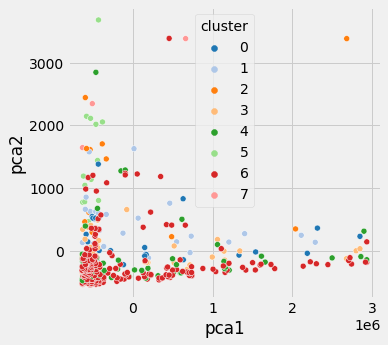

In [96]:
# Scatterplot of our clusters, reduced to two dimensions
plt.figure(figsize=(5,5))
ax= sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=pca_df, palette='tab20')
plt.show()

The clusters don't look spheric and they are overlapping, caused by pretty large variances. Perhaps with our data k-Means isn't the best model to apply.

Variances among features (PCA components)
-----

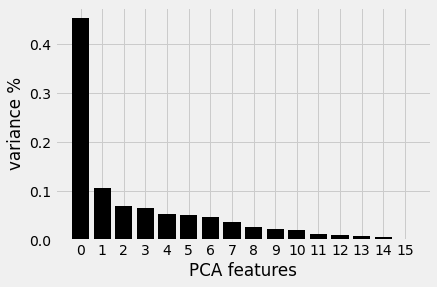

In [97]:
# Standardising and plotting the variances of the features
X_std = StandardScaler().fit_transform(df_poicount.iloc[:, 3:])
pca = PCA(n_components=16)

principalComponents = pca.fit_transform(X_std)
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)


PCA_components = pd.DataFrame(principalComponents)

It's too simplified, if most of the clustering is based on just one dimension.

Text(0, 0.5, 'PCA 2')

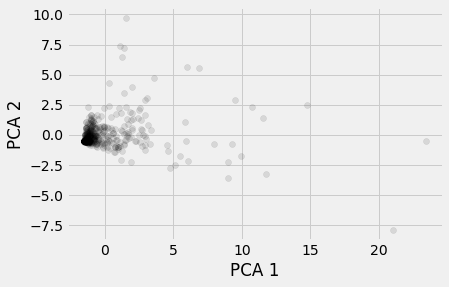

In [98]:
# Plotting the most influencial two features
plt.scatter(PCA_components[0], PCA_components[1], alpha= 0.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')